# **Assignment 3 - Part C_1**

## **Low level: Using tensorflow data structure to build a 3 layer neural network without auto differentiation primitives**

In [1]:
##Importing the required libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf

In [2]:
##Initializing the weights
a = tf.constant([[1,2,3], [4,5,6]])
a.shape

TensorShape([2, 3])

In [3]:
##Initializing the bias
bias = tf.constant([[1], [0.5]])
bias.shape

TensorShape([2, 1])

In [4]:
##Generate random values for x - shape: 500 * 3
n = 500
d = 3
x = tf.random.normal([n,d], -1, 1, tf.float64, seed=1)
x.shape

TensorShape([500, 3])

In [5]:
##Generating 3d non-linear input and calculating y_true values
a = tf.cast(a, tf.float64)
bias = tf.cast(bias, tf.float64)
x = tf.cast(x, tf.float64)

## y1 = x_1^2 + 2 * x_2^2 + 3 * x_3^2 + x_1 + 2 * x_2 + 3 * x_3 + 1
## y2 = 4 * x_1^2 + 5 * x_2^2 + 6 * x_3^2 + 4 * x_1 + 5 * x_2 + 6 * x_3 + 0.5
##Calculating actual output for the data

a = tf.transpose(a)
bias = tf.transpose(bias)
y_true = tf.matmul(x ** 2, a) + tf.matmul(x, a) + bias

##Checking shapes for input, weight, bias and output tensors
print(f'x: {x.shape}, weights: {a.shape}, bias: {bias.shape}, y: {y_true.shape}')

x: (500, 3), weights: (3, 2), bias: (1, 2), y: (500, 2)


In [37]:
##Visualizing the data distribution using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_jobs=5).fit_transform(x)
tsne.shape

(500, 2)

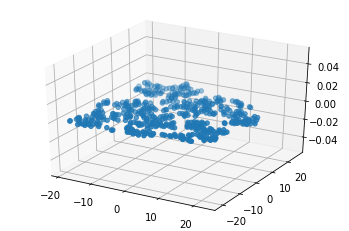

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [39]:
##Function for tsne plot visualization
def tsne_plot(tsne, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne[:, 0], tsne[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(tsne[:, 0], tsne[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

In [7]:
# A layer that creates an activity regularization loss
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

In [26]:
##Defining the linear layer
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        self.inputs = inputs
        return tf.matmul(inputs, self.w) + self.b

    def backward(self, gradient):
      self.inputs = tf.cast(self.inputs, tf.float64)
      self.inputs = tf.transpose(self.inputs)
      self.weights = tf.cast(self.weights, tf.float64)
      self.weights_gradient = tf.matmul(self.inputs, gradient)
      self.bias_gradient = gradient.sum(axis=0)
      self.weights = tf.transpose(self.weights)
      self.x_gradient = tf.matmul(gradient, self.weights)
      return self.x_gradient

    def update(self, lr):
      self.weights = self.weights - lr * self.weights_gradient
      self.bias = self.bias - lr * self.bias_gradient

In [27]:
##Defining custom loss 
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    loss_1 = ((y_pred - y_true) ** 2)
    loss_1 = tf.reduce_mean(loss_1)
    return loss_1
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

##Defining model class
class MLP(keras.layers.Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(10)
        self.linear_2 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        return self.linear_2(x)

    def backward(self, output_gradient):
      linear2_gradient = self.linear_2.backward(output_gradient)
      relu_gradient = tf.nn.relu(linear2_gradient)
      linear1_gradient = self.linear_1.backward(relu_gradient)
      return linear1_gradient

    def update(self, lr):
      self.linear_2.update(lr)
      self.linear_1.update(lr)

loss = MSE()
mlp = MLP()
y = mlp(x)
y = tf.cast(y, tf.float64)
print(y.shape)
loss_value = loss(y, y_true)
print(loss_value)

(500, 2)
tf.Tensor(268.51867277044425, shape=(), dtype=float64)


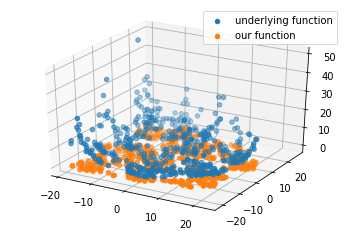

In [40]:
tsne_plot(tsne, y_true, y)

In [36]:
# Test just one forward and backward step
y = mlp(x)
y = tf.cast(y, tf.float64)
loss_value = loss(y, y_true)
print(loss_value)
loss_gradient = loss.backward()
loss_gradient = tf.cast(loss_gradient, tf.float64)
# mlp.backward(loss_gradient)
# mlp.update(0.01)
#optimizer.step()

y = mlp(x)
y = tf.cast(y, tf.float64)
loss_value = loss(y, y_true)
print(loss_value)

tf.Tensor(268.51867277044425, shape=(), dtype=float64)
tf.Tensor(268.51867277044425, shape=(), dtype=float64)


In [46]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = mlp(x)
    y_pred = tf.cast(y_pred, tf.float64)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    # model.backward(gradient_from_loss)
    # model.update(lr)

fit(x, y_true, model=mlp, loss=loss, lr=0.01, num_epochs=50)

Epoch 0, loss 268.51867277044425
Epoch 1, loss 268.51867277044425
Epoch 2, loss 268.51867277044425
Epoch 3, loss 268.51867277044425
Epoch 4, loss 268.51867277044425
Epoch 5, loss 268.51867277044425
Epoch 6, loss 268.51867277044425
Epoch 7, loss 268.51867277044425
Epoch 8, loss 268.51867277044425
Epoch 9, loss 268.51867277044425
Epoch 10, loss 268.51867277044425
Epoch 11, loss 268.51867277044425
Epoch 12, loss 268.51867277044425
Epoch 13, loss 268.51867277044425
Epoch 14, loss 268.51867277044425
Epoch 15, loss 268.51867277044425
Epoch 16, loss 268.51867277044425
Epoch 17, loss 268.51867277044425
Epoch 18, loss 268.51867277044425
Epoch 19, loss 268.51867277044425
Epoch 20, loss 268.51867277044425
Epoch 21, loss 268.51867277044425
Epoch 22, loss 268.51867277044425
Epoch 23, loss 268.51867277044425
Epoch 24, loss 268.51867277044425
Epoch 25, loss 268.51867277044425
Epoch 26, loss 268.51867277044425
Epoch 27, loss 268.51867277044425
Epoch 28, loss 268.51867277044425
Epoch 29, loss 268.51867

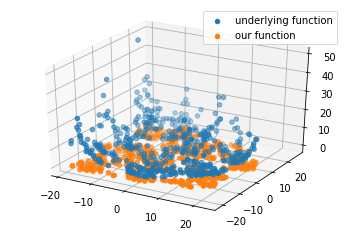

In [48]:
tsne_plot(tsne, y_true, mlp(x))